In [27]:
%matplotlib inline

import os
import random
import time
import datetime
import copy
from decimal import Decimal, ROUND_HALF_UP

from netpyne import specs, sim
import matplotlib.pyplot as plt
import numpy as np
from netpyne import specs, sim
from neuron import h
import pandas as pd

### SETTINGS ##################

read_folder = 'Ground truth SWCs/Small'
simplify = False
SEED = 0
cells = 9

square_size = 20

sigma_gnabars = np.linspace(0.06, 0.2, num=20)
mu_gnabars = np.linspace(0.12, 0.6, num=20)

data = np.zeros((square_size, square_size))

impulse_delay = 10 #ms
microscope_recording_duration = 0.150*1e3  #ms


In [ ]:

for uu, sigma_gnabar in enumerate(sigma_gnabars):
    for vv, mu_gnabar in enumerate(mu_gnabars):
        
        gnabars = np.random.normal(mu_gnabar, sigma_gnabar, cells)
        

        netParams = None
        simConfig = None

        netParams = specs.NetParams()
        netParams.sizeZ = 10


        random.seed(SEED)

        ### Data storage arrays ##########
        swc_filenames = []
        for file in os.listdir(read_folder):
            if os.path.splitext(file)[-1] == '.swc':
                swc_filenames.append(file)

        swcs = []
        for ii in range(cells):
            swc_fname = random.choice(swc_filenames)
            swcs.append(swc_fname)

        X = np.zeros(cells)
        Y = np.zeros(cells)
        Z = np.zeros(cells)

        size = np.ceil(np.sqrt(cells)).astype(int)
        for ii in range(cells):
            rel_coords = np.array([np.floor(ii / size), ii % size])
            rel_coords = rel_coords + 1
            rel_coords = rel_coords / (size + 2)

            X[ii] = netParams.sizeX * rel_coords[0]
            Y[ii] = netParams.sizeY * rel_coords[1]
            Z[ii] = netParams.sizeZ * 0.5

        ###########################

        cell_labels = []
        for ii in range(cells):
            swc_fname = swcs[ii]

            label = f'trace_{ii:04d}'

            cellRule = netParams.importCellParams(
                label=label, 
                conds={'cellType': label},
                fileName=os.path.join(read_folder, swc_fname), 
                cellName=label,
                )

            cell_labels.append(label)

            # For convenience, we'll rename the first soma section in the morphology from `soma_0` to `soma`.
            netParams.renameCellParamsSec(label, 'soma_0', 'soma')


            for secName in cellRule['secs']:
                cellRule['secs'][secName]['geom']['cm'] = 1
                cellRule['secs'][secName]['mechs']['hh'] = {
                    'gnabar': gnabars[ii], 
                    'gkbar': 0.036, 
                    'gl': 0.003, 
                    'el': -70,
                    }

            cellRule_dict = cellRule.todict()
            for jj, secName in enumerate(cellRule['secs']):

                parentX = cellRule_dict['secs'][secName]['topol'].get('parentX')
                childX = cellRule_dict['secs'][secName]['topol'].get('childX')

                if (parentX == 1.0 or parentX == 0.0) and (childX == 0.0):
                    pass
                elif parentX == {} and childX == {}:
                    pass #soma

                elif parentX is None and childX is None:
                    pass 
                elif type(parentX) is float and type(childX) is float:
                    # clip to 0-1, round up for 0.5
                    cellRule['secs'][secName]['topol']['parentX'] = max(
                        min(float(Decimal(parentX).to_integral_value(rounding=ROUND_HALF_UP)), 1.0), 
                        0.0)

                    # clip to 0-1
                    cellRule['secs'][secName]['topol']['childX'] = max(
                        min(float(round(childX)), 1.0), 
                        0.0)

        #             print(f"{parentX} --> {cellRule_dict['secs'][secName]['topol']['parentX']}\t" 
        #                   f"{childX} --> {cellRule_dict['secs'][secName]['topol']['childX']}")

                else:
                    raise ValueError('Expected parentX and childX relative positions to be floats between 0-1.'
                                     f'\n Instead, got parentX: {parentX} and childX: {childX}')

            if simplify:
                # Postprocessing to allow for output
                for mm, secName in enumerate(cellRule['secs']):

                    section_pts = cellRule['secs'][secName]['geom']['pt3d']

                    if len(section_pts) > 1:
                        old_pts = section_pts
                        cellRule['secs'][secName]['geom']['pt3d'] = [old_pts[0], old_pts[1]] # Linear approx


            netParams.popParams[label] = {'cellType'  : label,
                                          'cellModel' : 'HH3D', 
                                          'numCells'  : 1,
                                          'xRange'    : [X[ii]-1, X[ii]+1], 
                                          'yRange'    : [Y[ii]-1, Y[ii]+1], 
                                          'zRange'    : [Z[ii]-1, Z[ii]+1], }

        ## Synaptic mechanism parameters
        netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.8, 'tau2': 5.3, 'e': 0}  # NMDA synaptic mechanism
        netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.6, 'tau2': 8.5, 'e': -75}  # GABA synaptic mechanism

        netParams.stimSourceParams[f'Probe'] = {'type': 'IClamp', 'del': impulse_delay, 'dur': 300, 'amp': 5}
        for label in cell_labels:
            netParams.stimTargetParams[f'Probe->{label}'] = {'source': 'Probe', 
                                                         'sec': 'soma',
                                                         'loc': 0.5,
                                                         'conds': {'cellType': label}}

        # Simulation options
        simConfig = specs.SimConfig()        # object of class SimConfig to store simulation configuration

        simConfig.duration = 0.150*1e3           # Duration of the simulation, in ms
        simConfig.dt = 0.005                 # Internal integration timestep to use
        simConfig.verbose = False            # Show detailed messages
        simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
        simConfig.recordCells = range(cells)
        simConfig.recordStep = 0.25             # Step size in ms to save data (e.g. V traces, LFP, etc)

        simConfig.analysis['plotSpikeStats'] = {'stats' : ['rate'],
                                               'showFig' : False}

        # Create network and run simulation
        sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig)

        spike_times = np.array(sim.simData['spkt'])
        spike_ids = np.array(sim.simData['spkid']).astype(int)

        spike_freq = np.zeros(cells)

        for tt, sid in zip(spike_times, spike_ids):
            spike_freq[sid] = spike_freq[sid] + 1

        spike_freq =  spike_freq / (microscope_recording_duration) * 1000

        unique_spike_freqs = len(np.unique(spike_freq))
        
        data[uu, vv] = unique_spike_freqs

In [29]:
data

array([[1., 3., 3., 3., 5., 4., 6., 7., 5., 5., 4., 6., 5., 5., 4., 4.,
        4., 4., 3., 3.],
       [3., 3., 2., 4., 4., 3., 7., 4., 6., 7., 5., 6., 5., 4., 5., 4.,
        3., 4., 4., 3.],
       [3., 3., 3., 5., 4., 5., 5., 7., 5., 6., 6., 6., 5., 6., 5., 5.,
        3., 4., 4., 4.],
       [2., 5., 2., 3., 3., 3., 5., 5., 6., 6., 5., 5., 4., 5., 5., 4.,
        3., 4., 5., 4.],
       [3., 2., 2., 4., 4., 3., 5., 5., 7., 7., 6., 6., 5., 5., 4., 4.,
        4., 3., 3., 4.],
       [3., 5., 4., 3., 3., 6., 7., 5., 6., 4., 5., 5., 7., 5., 5., 4.,
        3., 5., 3., 5.],
       [3., 5., 5., 4., 8., 6., 3., 5., 8., 7., 7., 6., 5., 6., 5., 5.,
        5., 3., 4., 3.],
       [2., 3., 3., 4., 6., 5., 7., 7., 5., 7., 5., 5., 4., 5., 4., 5.,
        4., 5., 5., 4.],
       [2., 3., 3., 3., 5., 3., 5., 4., 7., 7., 7., 6., 6., 5., 5., 5.,
        5., 4., 4., 5.],
       [3., 4., 3., 3., 4., 5., 5., 6., 7., 5., 6., 5., 7., 6., 3., 5.,
        4., 4., 4., 5.],
       [5., 3., 6., 6., 4., 4.

0.3726315789473684

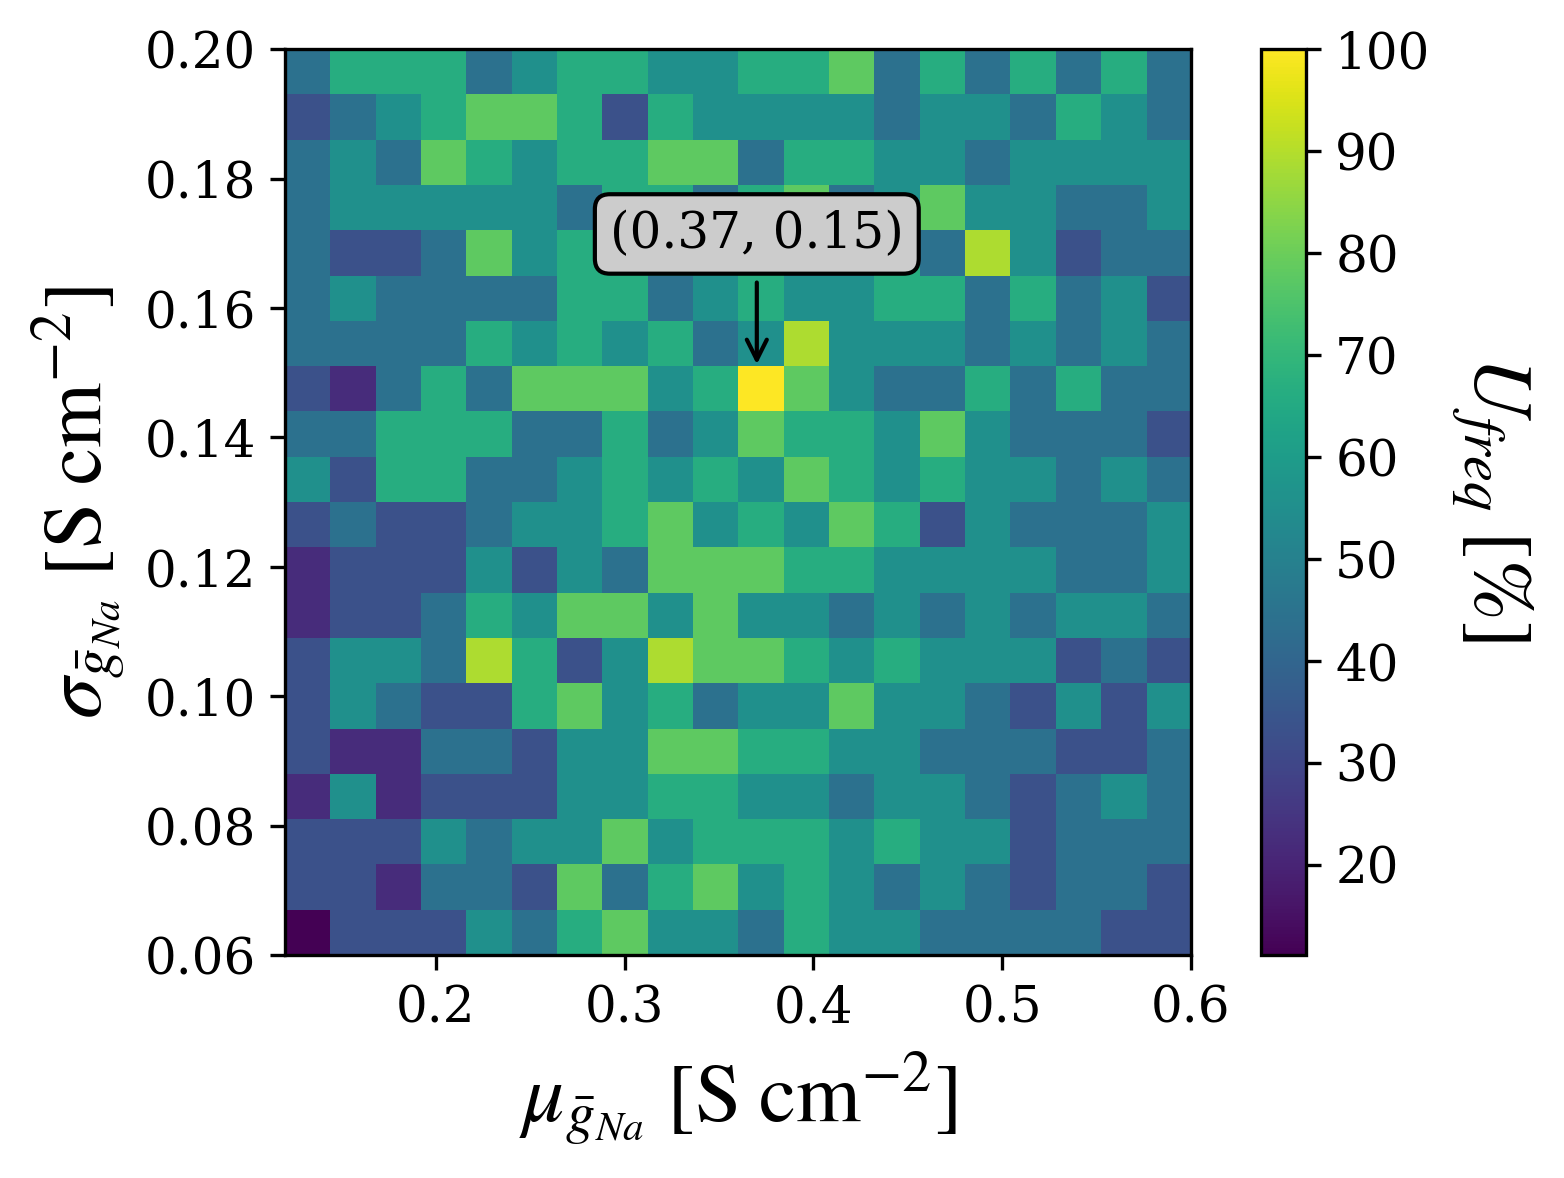

In [115]:
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Cambria Math"] + plt.rcParams["font.serif"]

fig = plt.figure(1, dpi=300)
ax = fig.add_subplot(111, autoscale_on=False)
ax.set_xlim(left=mu_gnabars[0], right=mu_gnabars[-1])
ax.set_ylim(bottom=sigma_gnabars[0], top=sigma_gnabars[-1])

aspect = (mu_gnabars[-1] - mu_gnabars[0]) / (sigma_gnabars[-1] - sigma_gnabars[0])
plt.imshow(data/cells*100, 
           extent=[mu_gnabars[0], mu_gnabars[-1], sigma_gnabars[-1], sigma_gnabars[0]], 
           aspect=aspect)
plt.ylabel(r'$\sigma_{\bar{g}_{Na}}\;\mathrm{[S\;cm}^{-2}\mathrm{]}$', fontsize=20)
plt.xlabel(r'$\mu_{\bar{g}_{Na}}\;\mathrm{[S\;cm}^{-2}\mathrm{]}$', fontsize=20)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_ylabel('$U_{freq}\;\mathrm{ [\%]}$ ', rotation=270, fontsize=20)

max_idx = np.unravel_index(np.argmax(data), data.shape)
max_pos = np.round((mu_gnabars[max_idx[1]], sigma_gnabars[max_idx[0]]),2)

ax.annotate(f"{tuple(max_pos)}", # this is the text
                 max_pos, # these are the coordinates to position the label
               arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 bbox=dict(boxstyle="round", fc="0.8"),
                 ha='center')

mu_gnabars[max_idx[1]]